In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/electric-power-consumption-data-set/household_power_consumption.txt


In [2]:
!pip install pmdarima
!pip install prophet
import pandas as pd
import os
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from pmdarima import auto_arima
from prophet import Prophet
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import warnings
warnings.filterwarnings('ignore')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 29.6 MB/s eta 0:00:00


In [3]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("uciml/electric-power-consumption-data-set")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/electric-power-consumption-data-set


In [4]:
# Construct full path to the text file
data_file = os.path.join(path, "household_power_consumption.txt")

# Load the data
df = pd.read_csv(
    data_file,
    sep=';',                     # because it's semicolon-separated
    parse_dates=[[0, 1]],        # combine Date and Time columns
    infer_datetime_format=True,
    low_memory=False,
    na_values='?'
)
# Rename the combined column
df.rename(columns={'Date_Time': 'Datetime'}, inplace=True)

# Show first few rows
df.head()

,Datetime,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
1,2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2,2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
3,2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
4,2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0


In [5]:
df.shape

(2075259, 8)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075259 entries, 0 to 2075258
Data columns (total 8 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   Datetime               datetime64[ns]
 1   Global_active_power    float64       
 2   Global_reactive_power  float64       
 3   Voltage                float64       
 4   Global_intensity       float64       
 5   Sub_metering_1         float64       
 6   Sub_metering_2         float64       
 7   Sub_metering_3         float64       
dtypes: datetime64[ns](1), float64(7)
memory usage: 126.7 MB


In [7]:
df.describe().T

,count,mean,min,25%,50%,75%,max,std
Datetime,2075259,2008-12-06 07:13:00,2006-12-16 17:24:00,2007-12-12 00:18:30,2008-12-06 07:13:00,2009-12-01 14:07:30,2010-11-26 21:02:00,NaN
Global_active_power,2049280.0,1.091615,0.076,0.308,0.602,1.528,11.122,1.057294
Global_reactive_power,2049280.0,0.123714,0.0,0.048,0.1,0.194,1.39,0.112722
Voltage,2049280.0,240.839858,223.2,238.99,241.01,242.89,254.15,3.239987
Global_intensity,2049280.0,4.627759,0.2,1.4,2.6,6.4,48.4,4.444396
Sub_metering_1,2049280.0,1.121923,0.0,0.0,0.0,0.0,88.0,6.153031
Sub_metering_2,2049280.0,1.29852,0.0,0.0,0.0,1.0,80.0,5.822026
Sub_metering_3,2049280.0,6.458447,0.0,0.0,1.0,17.0,31.0,8.437154


In [8]:
df.isnull().sum()/len(df) * 100  # Percentage of missing values

Datetime                 0.000000
Global_active_power      1.251844
Global_reactive_power    1.251844
Voltage                  1.251844
Global_intensity         1.251844
Sub_metering_1           1.251844
Sub_metering_2           1.251844
Sub_metering_3           1.251844
dtype: float64

In [9]:
df.duplicated().sum()  # Check for duplicatese

0

Data PreProcessing

In [10]:
# Set datetime as index
df.set_index('Datetime', inplace=True)

# Convert numeric columns
cols_to_numeric = ['Global_active_power', 'Global_reactive_power', 'Voltage', 
                   'Global_intensity', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']

df[cols_to_numeric] = df[cols_to_numeric].apply(pd.to_numeric, errors='coerce')

# Check missing values
print("Missing values per column:")
print(df.isnull().sum())

# Drop rows with missing values
df.dropna(inplace=True)

# Final shape
print(f"Final shape after cleaning: {df.shape}")

Missing values per column:
Global_active_power      25979
Global_reactive_power    25979
Voltage                  25979
Global_intensity         25979
Sub_metering_1           25979
Sub_metering_2           25979
Sub_metering_3           25979
dtype: int64
Final shape after cleaning: (2049280, 7)


Time Series Resampling & Feature Engineering
Since the dataset is in minute-level frequency, we will resample it to hourly averages to reduce noise and make it suitable for short-term forecasting. We will also extract time-based features such as hour, day of the week, and whether it's a weekend.

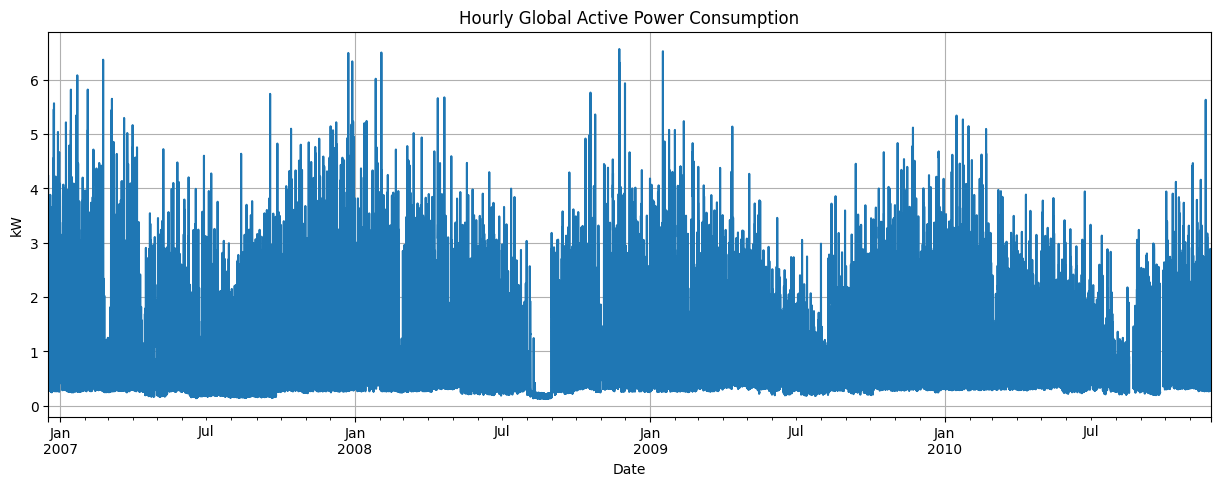

In [11]:
# Resample the data to hourly frequency using mean
df_hourly = df['Global_active_power'].resample('H').mean()

# Visualize resampled data
plt.figure(figsize=(15, 5))

df_hourly.plot()
plt.title("Hourly Global Active Power Consumption")
plt.xlabel("Date")
plt.ylabel("kW")
plt.grid(True)
plt.show()

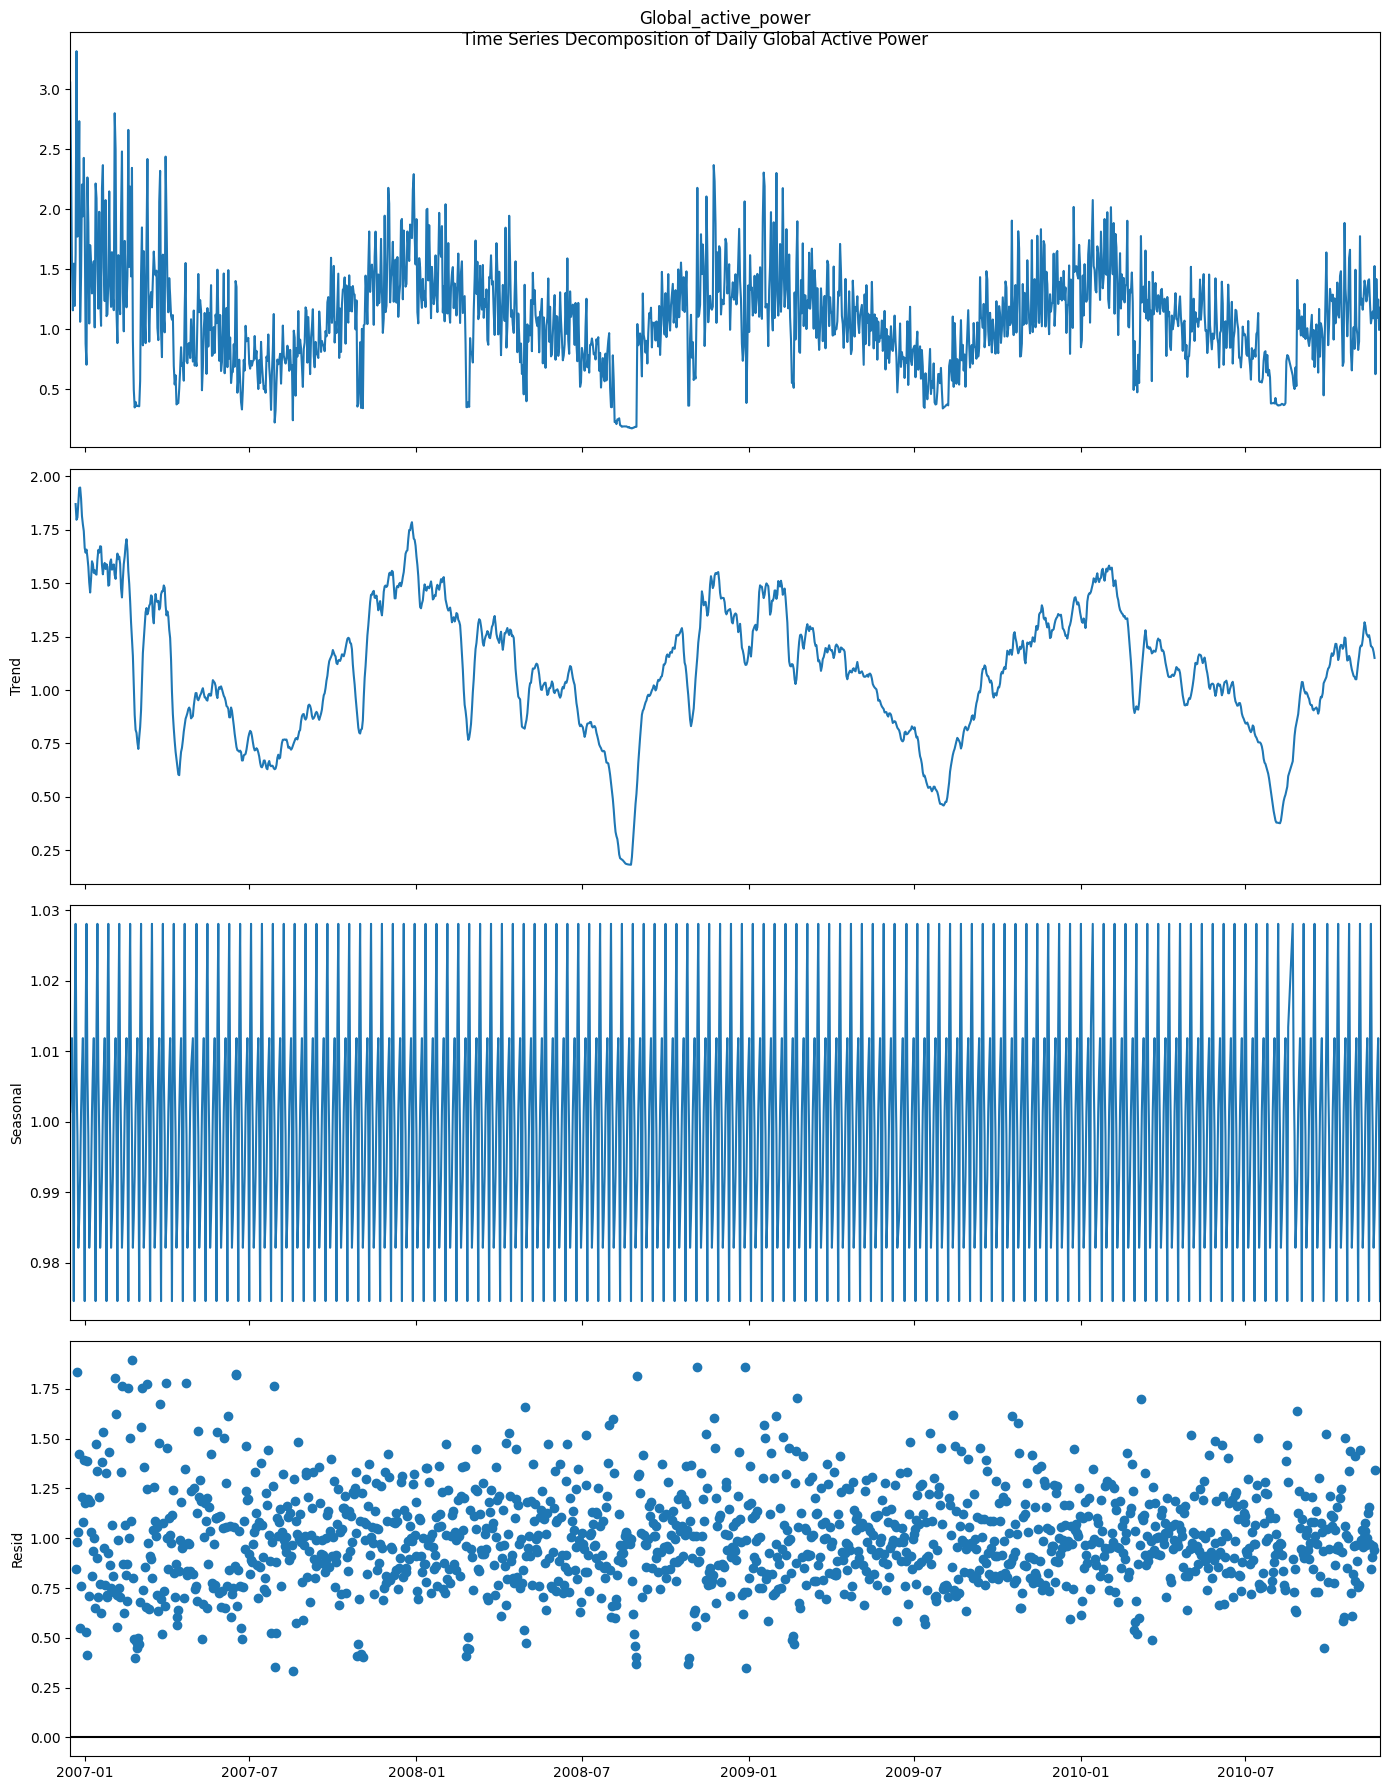

In [12]:
# Resample to daily average to make it suitable for decomposition
daily_data = df['Global_active_power'].resample('D').mean()

# Drop missing values
daily_data.dropna(inplace=True)

# Decompose the time series (additive model)
decomposition = seasonal_decompose(daily_data, model='multiplicative', period=12)  # 7 for weekly seasonality

# Plot the decomposed components
plt.rcParams.update({'figure.figsize': (14, 18)})
decomposition.plot()
plt.suptitle('Time Series Decomposition of Daily Global Active Power')
plt.show()

<Axes: >

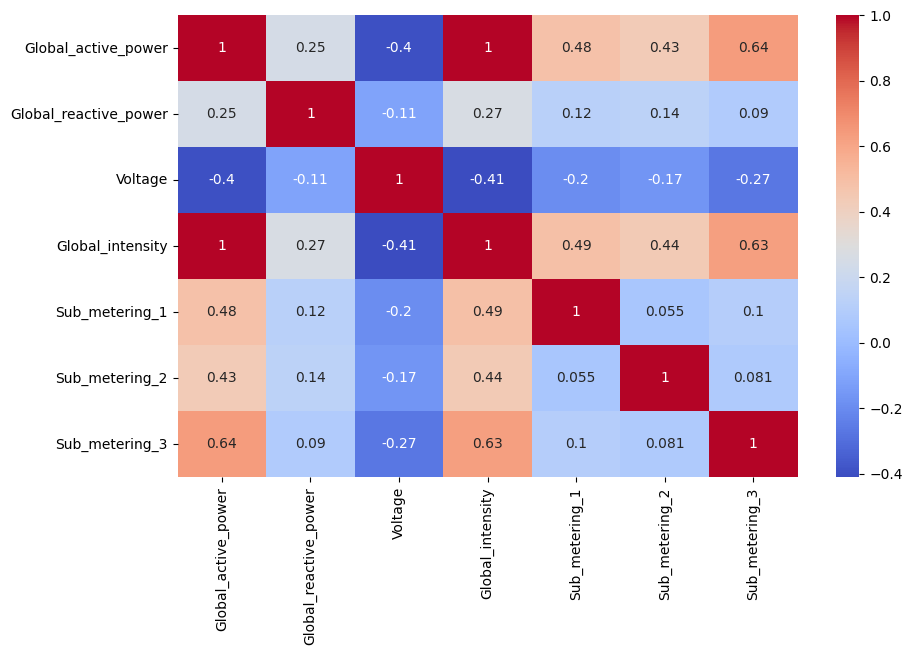

In [13]:
plt.figure(figsize=(10, 6))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')

Prepare Data for Modeling

In [14]:
# We'll use hourly resampled data
data = df['Global_active_power'].resample('H').mean().dropna()

# Train-test split: use data until end of 2009 for training, 2010 for testing
train = data[:'2009']
test = data['2010':]

Model 1: ARIMA

In [15]:
from pmdarima import auto_arima

from pmdarima import auto_arima

from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(train, order=(1, 1, 1))  # Choose p,d,q manually
model_fit = model.fit()

forecast_arima = model_fit.forecast(steps=len(test))





# Forecast for test length
# forecast_arima = arima_model.predict(n_periods=len(test))

# Evaluation
mae_arima = mean_absolute_error(test, forecast_arima)
rmse_arima = np.sqrt(mean_squared_error(test, forecast_arima))
r2_arima = r2_score(test, forecast_arima)

# Print all scores
print(f"ARIMA MAE: {mae_arima:.3f}, RMSE: {rmse_arima:.3f}, R² Score: {r2_arima:.3f}")

ARIMA MAE: 0.745, RMSE: 0.873, R² Score: -0.245


Model 2: Prophet

In [16]:
# rename the columns
df = df.rename(columns={'Datetime': 'ds', 'Global_active_power': 'y'})
df.head()

,y,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
Datetime,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0


In [17]:
# Prophet needs dataframe with ds and y columns
train_prophet = train.reset_index().rename(columns={'Datetime': 'ds', 'Global_active_power': 'y'})
train_prophet.head()

,ds,y
0,2006-12-16 17:00:00,4.222889
1,2006-12-16 18:00:00,3.632200
2,2006-12-16 19:00:00,3.400233
3,2006-12-16 20:00:00,3.268567
4,2006-12-16 21:00:00,3.056467


In [18]:
# Fit Prophet
model_prophet = Prophet()
model_prophet.fit(train_prophet)

# Create future dataframe
future = model_prophet.make_future_dataframe(periods=len(test), freq='H')
forecast_prophet = model_prophet.predict(future)

# Extract only forecast values
forecast_p = forecast_prophet.set_index('ds')['yhat'][-len(test):]

# Evaluation
mae_prophet = mean_absolute_error(test, forecast_p)
rmse_prophet = np.sqrt(mean_squared_error(test, forecast_p))
r2_prophet = r2_score(test, forecast_p)

print(f"Prophet MAE: {mae_prophet:.3f}, RMSE: {rmse_prophet:.3f}, R² Score: {r2_prophet:.3f}")

17:38:20 - cmdstanpy - INFO - Chain [1] start processing
17:38:28 - cmdstanpy - INFO - Chain [1] done processing


Prophet MAE: 0.647, RMSE: 0.846, R² Score: -0.170


Model 3: XGBoost

In [19]:
# Create time-based features for XGBoost
df_xgb = data.to_frame()
df_xgb['hour'] = df_xgb.index.hour
df_xgb['day'] = df_xgb.index.day
df_xgb['weekday'] = df_xgb.index.weekday
df_xgb['month'] = df_xgb.index.month

# Lag features
for i in range(1, 25):
    df_xgb[f'lag_{i}'] = df_xgb['Global_active_power'].shift(i)

df_xgb.dropna(inplace=True)

# Split
X = df_xgb.drop('Global_active_power', axis=1)
y = df_xgb['Global_active_power']
X_train = X[:'2009']
y_train = y[:'2009']
X_test = X['2010':]
y_test = y['2010':]

# Train XGBoost
xgb_model = xgb.XGBRegressor()
xgb_model.fit(X_train, y_train)

# Predict
y_pred_xgb = xgb_model.predict(X_test)


# Evaluation
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
r2_xgb = r2_score(y_test, y_pred_xgb)

print(f"XGBoost MAE: {mae_xgb:.3f}, RMSE: {rmse_xgb:.3f}, R² Score: {r2_xgb:.3f}")

XGBoost MAE: 0.350, RMSE: 0.501, R² Score: 0.589


Final Comparison Table

In [20]:
print("📋 Forecasting Model Performance:\n")
print(f"ARIMA    → MAE: {mae_arima:.3f}, RMSE: {rmse_arima:.3f}, R²: {r2_arima:.3f}")
print(f"Prophet  → MAE: {mae_prophet:.3f}, RMSE: {rmse_prophet:.3f}, R²: {r2_prophet:.3f}")
print(f"XGBoost  → MAE: {mae_xgb:.3f}, RMSE: {rmse_xgb:.3f}, R²: {r2_xgb:.3f}")

📋 Forecasting Model Performance:

ARIMA    → MAE: 0.745, RMSE: 0.873, R²: -0.245
Prophet  → MAE: 0.647, RMSE: 0.846, R²: -0.170
XGBoost  → MAE: 0.350, RMSE: 0.501, R²: 0.589


Plot Actual vs Forecasted

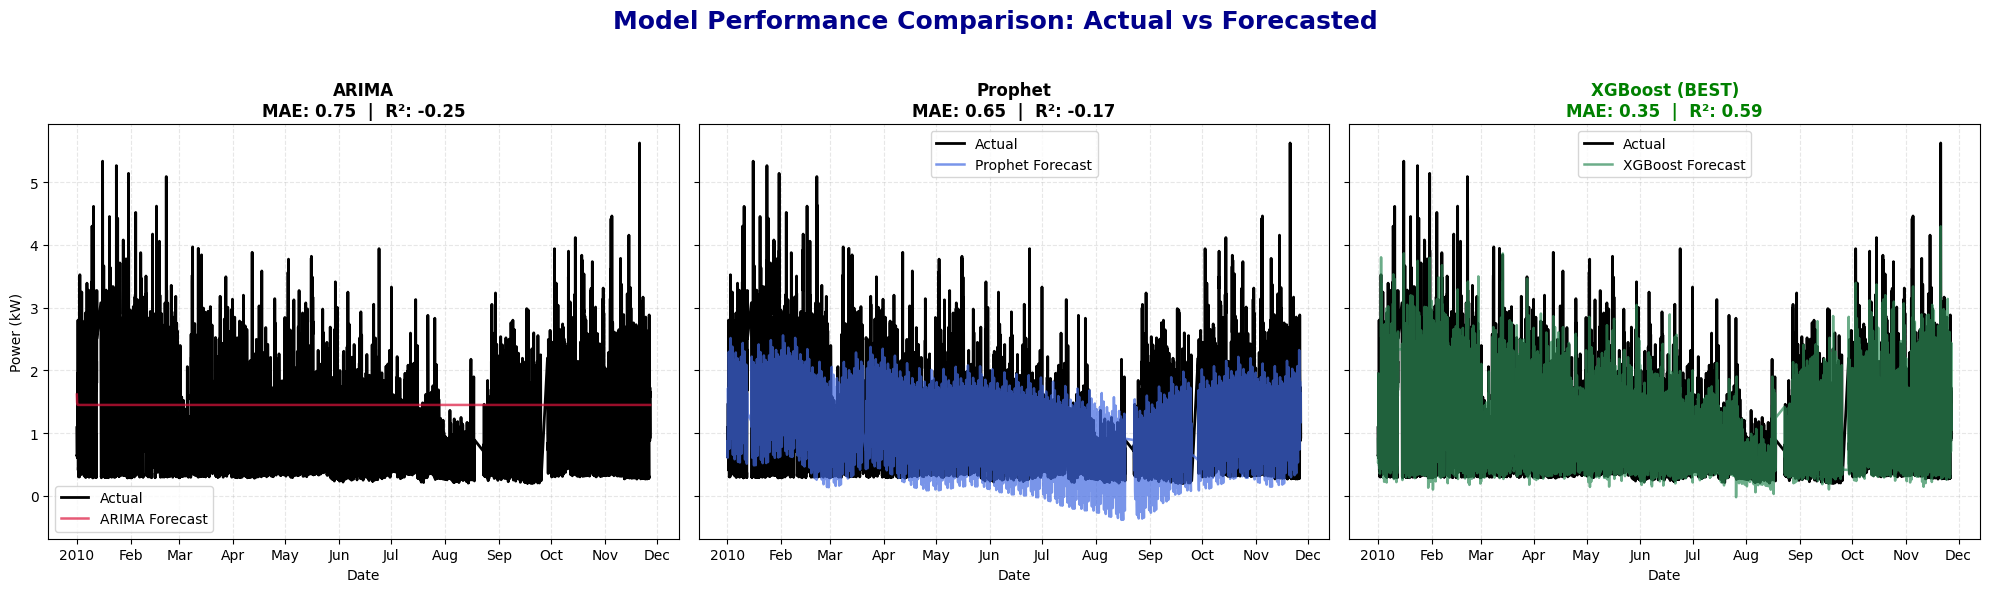

In [21]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Extract actual test values
if isinstance(test, pd.DataFrame):
    test_actual = test['Global_active_power']
else:
    test_actual = test

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(20, 6), sharey=True)
fig.suptitle('Model Performance Comparison: Actual vs Forecasted', fontsize=18, fontweight='bold', color='darkblue')

# Common styling variables
actual_color = 'black'
alpha_forecast = 0.7

# Plot 1: ARIMA
axes[0].plot(test_actual.index, test_actual.values, label='Actual', color=actual_color, linewidth=2)
axes[0].plot(test_actual.index, forecast_arima, label='ARIMA Forecast', color='crimson', alpha=alpha_forecast, linewidth=1.8)
axes[0].set_title(f'ARIMA\nMAE: {mae_arima:.2f}  |  R²: {r2_arima:.2f}', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Power (kW)')
axes[0].legend()
axes[0].grid(True, linestyle='--', alpha=0.3)

# Plot 2: Prophet
axes[1].plot(test_actual.index, test_actual.values, label='Actual', color=actual_color, linewidth=2)
axes[1].plot(test_actual.index, forecast_p, label='Prophet Forecast', color='royalblue', alpha=alpha_forecast, linewidth=1.8)
axes[1].set_title(f'Prophet\nMAE: {mae_prophet:.2f}  |  R²: {r2_prophet:.2f}', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Date')
axes[1].legend()
axes[1].grid(True, linestyle='--', alpha=0.3)

# Plot 3: XGBoost
axes[2].plot(y_test.index, y_test.values, label='Actual', color=actual_color, linewidth=2)
axes[2].plot(y_test.index, y_pred_xgb, label='XGBoost Forecast', color='seagreen', alpha=alpha_forecast, linewidth=1.8)
axes[2].set_title(f'XGBoost (BEST)\nMAE: {mae_xgb:.2f}  |  R²: {r2_xgb:.2f}', fontsize=12, fontweight='bold', color='green')
axes[2].set_xlabel('Date')
axes[2].legend()
axes[2].grid(True, linestyle='--', alpha=0.3)

# Improve x-axis formatting
for ax in axes:
    ax.xaxis.set_major_locator(mdates.AutoDateLocator())
    ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))

# Final layout
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Leave space for suptitle
plt.show()


Final Conclusion
XGBoost outperformed both ARIMA and Prophet models in forecasting household energy consumption.
It achieved the lowest Mean Absolute Error (MAE: 0.35) and the highest R² score (0.59), effectively capturing non-linear trends, sharp fluctuations, and complex seasonal patterns.
In contrast, ARIMA and Prophet struggled with the dataset’s irregularities, resulting in higher errors and negative R² scores.
Therefore, XGBoost is the most suitable model for this forecasting task.